In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#making random numbers predictable
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#one-hot encoding of y
from keras.utils.np_utils import to_categorical

#make it pretty
sns.set(context = 'notebook', palette='cubehelix', style = 'dark')

In [93]:
#get data

train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/train.csv")



# Exploring the Data

In [94]:
Y_train = train['label']
X_train = train.drop(labels= ['label'], axis = 1)
#Check if dropped
X_train.shape

(42000, 784)

In [95]:
test.shape

(42000, 785)

In [96]:
Y_test = test['label']
X_test = test.drop(labels= ['label'], axis = 1)
#Test test
X_test.shape

(42000, 784)

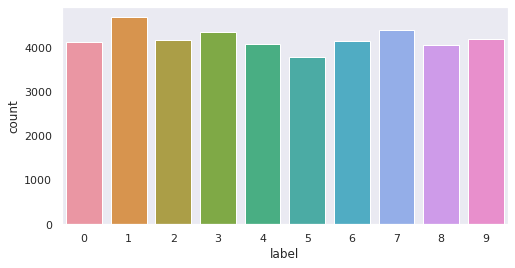

In [97]:
#See our training label distribution
plt.figure(figsize = (8,4))
sns.countplot(Y_train)
plt.show()

In [98]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [99]:
#check missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [100]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No missing values, yay

# Preprocessing

## Normalise

In [101]:
#To reduce effect of illumination, we normalise to greyscale
X_train = X_train / 255 
X_test = X_test/255


## Reshape data

In [102]:
img_width = 28
img_height = 28
channels = 1

In [103]:
#-1 in the shape makes it compatible with the original shape. 
#We want the new data to have shape (width, height, channels)

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)


In [104]:
X_train.shape

(42000, 28, 28, 1)

## One Hot Encoding 

In [105]:
#endoding y as a one hot vector of 10

Y_train = to_categorical(Y_train, num_classes = 10)

## Split into Train and Validation

In [106]:
#using a 90-10 ratio
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.10, shuffle = True)

#alt: use random seed instead of shuffle
#random_seed = 2
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(37800, 28, 28, 1) (37800, 10) (4200, 28, 28, 1) (4200, 10)


# Model Construction

 CNN Model: *Conv2D-ReLU -> Conv2D-ReLU -> MaxPool2D -> Dropout -> Conv2D-ReLU -> Conv2D-ReLU -> MaxPool2D -> Dropout -> Flatten -> Dense -> Dropout 

## Build

In [107]:
#Build

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (img_width,img_height,channels)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## RMSProp Optimizer

In [108]:
#Optimiser

#using categorical crossentropy for categorical loss
#using RMSProp with default values
#Gradient Stochastic Descent is slower

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

## Compile

In [109]:
#Compile
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

IMPORTANT change epoch sizes while demos, it takes a while to run. Use GPU, CPU has a hilariously long run time

In [110]:
epochs = 30
batch_size = 64


In [111]:
#train to see accuracy

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), 
                    verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
 - 4s - loss: 0.2212 - accuracy: 0.9306 - val_loss: 0.0668 - val_accuracy: 0.9800
Epoch 2/30
 - 4s - loss: 0.0678 - accuracy: 0.9795 - val_loss: 0.0660 - val_accuracy: 0.9850
Epoch 3/30
 - 4s - loss: 0.0551 - accuracy: 0.9847 - val_loss: 0.0495 - val_accuracy: 0.9864
Epoch 4/30
 - 4s - loss: 0.0460 - accuracy: 0.9867 - val_loss: 0.0457 - val_accuracy: 0.9874
Epoch 5/30
 - 4s - loss: 0.0416 - accuracy: 0.9880 - val_loss: 0.0294 - val_accuracy: 0.9917
Epoch 6/30
 - 4s - loss: 0.0379 - accuracy: 0.9890 - val_loss: 0.0271 - val_accuracy: 0.9924
Epoch 7/30
 - 4s - loss: 0.0368 - accuracy: 0.9896 - val_loss: 0.0340 - val_accuracy: 0.9910
Epoch 8/30
 - 4s - loss: 0.0333 - accuracy: 0.9904 - val_loss: 0.0273 - val_accuracy: 0.9914
Epoch 9/30
 - 4s - loss: 0.0348 - accuracy: 0.9902 - val_loss: 0.0299 - val_accuracy: 0.9905
Epoch 10/30
 - 4s - loss: 0.0328 - accuracy: 0.9902 - val_loss: 0.0753 - val_accuracy: 0.9860
Epoch 11/30
 - 4s - 

 Accuracy: 98.83

## Annealer

In [112]:
#Annealer
#Reduce learning by half if accuracy not improved in 3 epochs
#We use an annealer to decrease the learning rate so it converges to global minima and not local minima
#verbose=1 to give update messages
#min_lr: lower bound on learning rate

annealer = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [113]:
#using annealer
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), 
                    verbose = 2, callbacks= [annealer])

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
 - 4s - loss: 0.0475 - accuracy: 0.9896 - val_loss: 0.0431 - val_accuracy: 0.9888
Epoch 2/30
 - 4s - loss: 0.0508 - accuracy: 0.9887 - val_loss: 0.0597 - val_accuracy: 0.9857
Epoch 3/30
 - 4s - loss: 0.0582 - accuracy: 0.9883 - val_loss: 0.0398 - val_accuracy: 0.9910
Epoch 4/30
 - 4s - loss: 0.0541 - accuracy: 0.9879 - val_loss: 0.0420 - val_accuracy: 0.9893
Epoch 5/30
 - 4s - loss: 0.0571 - accuracy: 0.9874 - val_loss: 0.0357 - val_accuracy: 0.9914
Epoch 6/30
 - 4s - loss: 0.0586 - accuracy: 0.9867 - val_loss: 0.0429 - val_accuracy: 0.9895
Epoch 7/30
 - 4s - loss: 0.0625 - accuracy: 0.9862 - val_loss: 0.0342 - val_accuracy: 0.9902
Epoch 8/30
 - 4s - loss: 0.0693 - accuracy: 0.9856 - val_loss: 0.0492 - val_accuracy: 0.9879

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/30
 - 4s - loss: 0.0435 - accuracy: 0.9908 - val_loss: 0.0318 - val_accuracy: 0.9926
Epoch 10/30
 - 4s - loss: 0.0343 

Accuracy: 99.61

Annealer incresed the accuracy, try data augmentation to prevent overfitting

## Augmentation

In [114]:
#Augmenting the data by rondomly rotating images by 10 degrees

imggen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False) 

imggen.fit(X_train)

In [115]:
#fit model to check accuracy with the augmented

history = model.fit_generator(imggen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[annealer])



Epoch 1/30
 - 13s - loss: 0.3154 - accuracy: 0.9233 - val_loss: 0.0523 - val_accuracy: 0.9921
Epoch 2/30
 - 14s - loss: 0.2717 - accuracy: 0.9340 - val_loss: 0.0531 - val_accuracy: 0.9919
Epoch 3/30
 - 13s - loss: 0.2500 - accuracy: 0.9383 - val_loss: 0.0582 - val_accuracy: 0.9912
Epoch 4/30
 - 13s - loss: 0.2404 - accuracy: 0.9399 - val_loss: 0.0594 - val_accuracy: 0.9910

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 5/30
 - 13s - loss: 0.2291 - accuracy: 0.9418 - val_loss: 0.0598 - val_accuracy: 0.9902
Epoch 6/30
 - 13s - loss: 0.2319 - accuracy: 0.9435 - val_loss: 0.0602 - val_accuracy: 0.9907
Epoch 7/30
 - 14s - loss: 0.2191 - accuracy: 0.9428 - val_loss: 0.0610 - val_accuracy: 0.9898
Epoch 8/30
 - 13s - loss: 0.2154 - accuracy: 0.9452 - val_loss: 0.0577 - val_accuracy: 0.9900
Epoch 9/30
 - 13s - loss: 0.2145 - accuracy: 0.9450 - val_loss: 0.0568 - val_accuracy: 0.9910
Epoch 10/30
 - 13s - loss: 0.2126 - accuracy: 0.9445 - val_loss: 0.0532 - val_accuracy: 0

Accuracy: 95.55

# Model Evaluation

## Accuracy

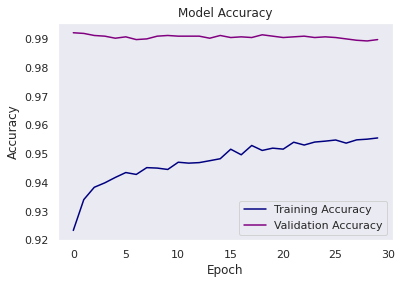

In [121]:
#Accuracy

plt.plot(history.history['accuracy'], color='navy', label="Training Accuracy")
plt.plot(history.history['val_accuracy'], color='purple', label="Validation Accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

## Loss

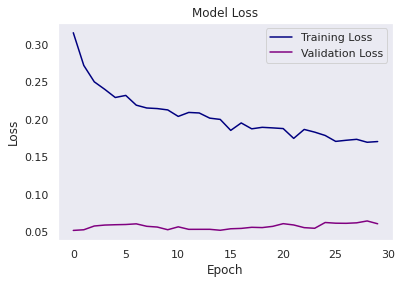

In [122]:
#Loss

plt.plot(history.history['loss'], color='navy', label="Training Loss")
plt.plot(history.history['val_loss'], color='purple', label="Validation Loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

## Confusion matrix

In [123]:
#Confusion Matrix

Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)

print(cm)

[[409   0   1   1   0   0   0   0   0   0]
 [  1 479   0   1   1   0   0   2   1   0]
 [  1   0 400   1   0   0   0   0   1   0]
 [  0   0   0 413   0   1   0   0   4   0]
 [  0   0   0   0 453   0   1   0   1   6]
 [  0   0   0   1   0 365   3   0   2   1]
 [  0   1   0   0   0   0 411   0   1   0]
 [  0   0   2   0   0   0   0 443   0   1]
 [  0   0   1   0   1   0   0   0 379   1]
 [  0   0   0   1   2   0   0   0   1 405]]


# Predicting Results

In [124]:
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

# Submission

In [125]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("DRSubmission.csv",index=False)
